In [ ]:
'''
Author: Ngawang Gurung
Date: 2024/07/24
'''

### Import Libraries

In [1]:
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt 
from mysql_connection import table_df # tabe_df function to convert sql table into pandas dataframe

### Loading Dataset

In [2]:
# Load data from the 'fc_transaction_base' table in the 'client_rw' database
df = table_df(database_name='client_rw', table_name='fc_transaction_base')

/home/user/Projects/eXtensoData/Data Analysis/RFM Analysis/mysql_connection.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql=query, con=con.connection)         # Pandas >= 2.2.0


In [3]:
df.head()

,tran_date,account_number,branch,product,lcy_amount,transaction_code,description1,dc_indicator,is_salary
0,2020-06-09,02XYZXYZ10017529992,15,SBA,14500.0,CI,ATM WDL /00463701/NABIL\NABIL,withdraw,0
1,2020-06-14,02XYZXYZ10017529992,15,SBA,20000.0,CI,ATM WDL /00463701/NABIL\NABIL,withdraw,0
2,2020-06-01,02XYZXYZ10017517823,15,SBA,4000.0,CI,ATM WDL /NICAV701/\Pharping\KT,withdraw,0
3,2020-06-05,02XYZXYZ10017517823,15,SBA,500.0,CI,ATM WDL /NICAV701/\Pharping\KT,withdraw,0
4,2020-06-12,02XYZXYZ10017517823,15,SBA,5000.0,CI,ATM WDL /NICAV701/\Pharping\KT,withdraw,0


In [4]:
# Remove rows with null 'account_number' values
df = df[pd.notnull(df['account_number'])]

### Which branch has how many user?

In [5]:
# Select 'branch' and 'account_number' columns and remove duplicate rows
filtered_df = df[['branch', 'account_number']].drop_duplicates()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


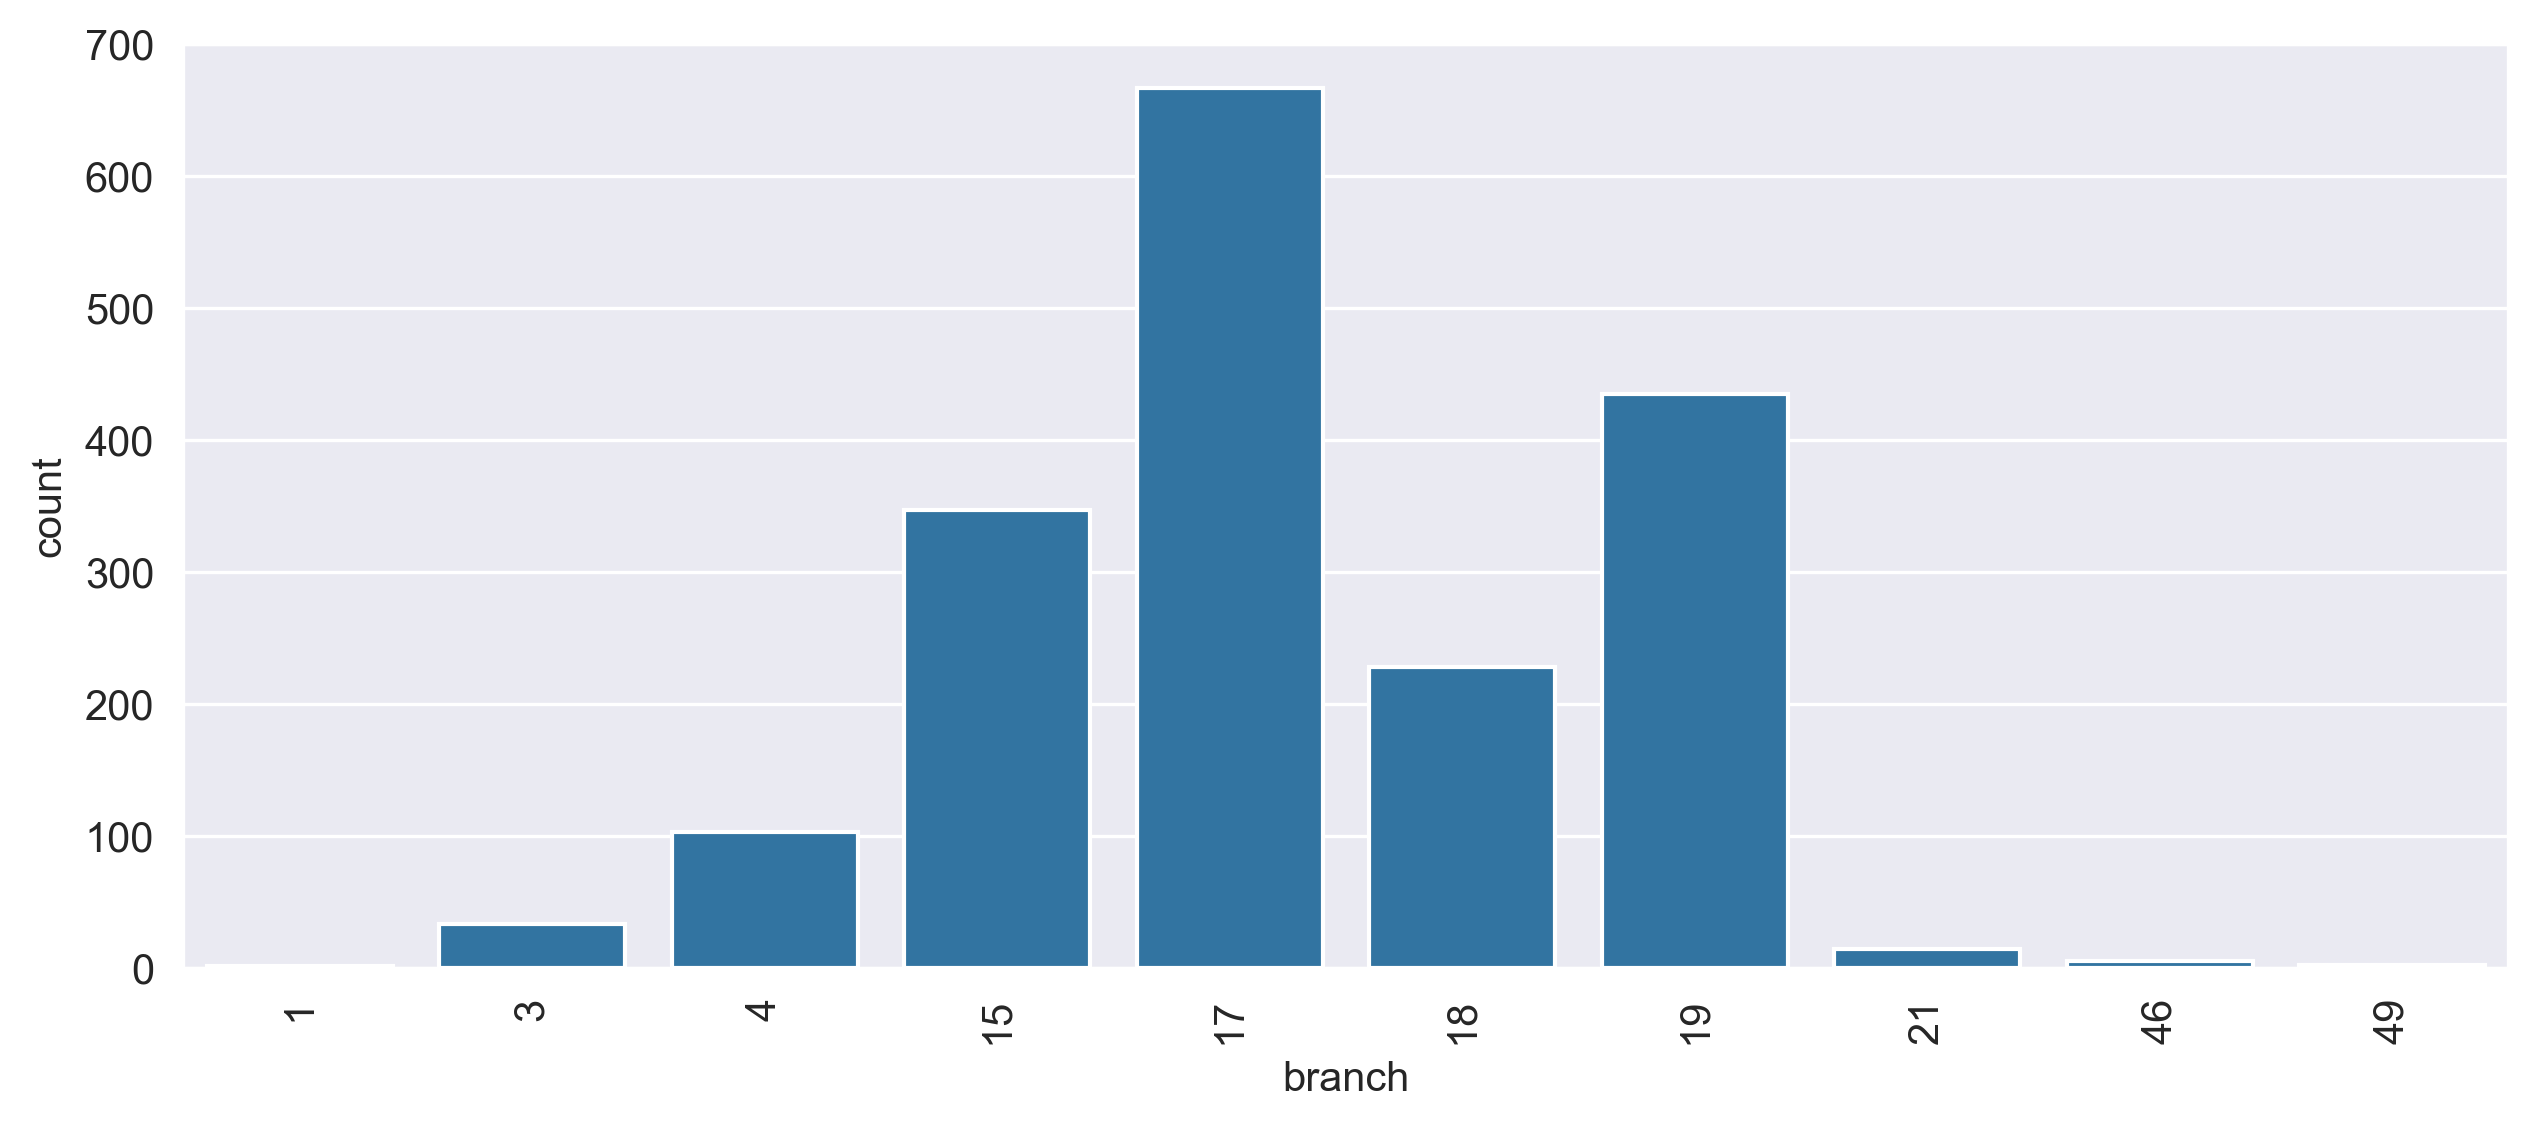

In [24]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10, 4), dpi=300)

# Create a bar plot showing the top 10 most frequent values in the 'branch' column of 'filtered_df'
ax = sns.barplot(data=filtered_df['branch'].value_counts().nlargest(10))

# Rotate x-axis tick labels by 90 degrees to improve readability
ax.tick_params(axis='x', rotation=90)

### RFM Analysis


RFM (Recency, Frequency, Monetary) analysis is a marketing technique used to segment customers based on their purchasing behavior. 

- It assesses how recently a customer made a purchase (Recency), how often they purchase (Frequency), and how much they spend (Monetary).

 - By combining these metrics into a single RFM score, businesses can identify their most valuable customers and tailor their marketing strategies accordingly.

In [22]:
# Generate summary statistics for numerical columns in the DataFrame
df.describe()

,tran_date,branch,lcy_amount
count,44243,44243.000000,4.424300e+04
mean,2020-07-10 05:06:55.387745024,16.563795,4.024458e+04
min,2020-06-01 00:00:00,1.000000,1.000000e-02
25%,2020-06-25 00:00:00,17.000000,9.500000e+02
50%,2020-07-13 00:00:00,17.000000,5.000000e+03
75%,2020-07-26 00:00:00,18.000000,2.000000e+04
max,2020-08-16 00:00:00,49.000000,1.028081e+07
std,NaN,4.134658,2.291303e+05


In [9]:
# Keep rows where 'lcy_amount' is non-negative
df = df[df['lcy_amount'] >= 0]

In [10]:
# Get the minimum and maximum dates from the 'tran_date' column
df['tran_date'].min(), df['tran_date'].max()

(Timestamp('2020-06-01 00:00:00'), Timestamp('2020-08-16 00:00:00'))


### Compute RFM metrics

In [9]:
# Define a reference date for calculating recency
PRESENT = dt.datetime(2020, 8, 17)

In [12]:
# - Recency: Days since the most recent transaction
# - Frequency: Number of transactions
# - Monetary: Total amount spent

rfm = df.groupby('account_number').agg({
    'tran_date': lambda date: (PRESENT - date.max()).days,
    'product': 'count',
    'lcy_amount': 'sum'
})

rfm

,tran_date,product,lcy_amount
account_number,,,
02XYZXYZ10015339701,8,27,9196718.71
02XYZXYZ10015571501,10,27,4895507.77
02XYZXYZ10015571601,33,3,29896.10
02XYZXYZ10015592101,4,43,11711419.97
02XYZXYZ10015593701,3,21,4187990.01
...,...,...,...
02XYZXYZ110017507494,3,19,84277.79
02XYZXYZ110017507511,20,35,108973.12
02XYZXYZ110017507523,3,19,406725.50


In [13]:
# Rename columns to reflect RFM metrics: recency, frequency, and monetary
rfm.columns = ['recency', 'frequency', 'monetary']

In [14]:
# Convert 'recency' column to integer type
rfm['recency'] = rfm['recency'].astype(int)

In [15]:
rfm.head()

,recency,frequency,monetary
account_number,,,
02XYZXYZ10015339701,8,27,9196718.71
02XYZXYZ10015571501,10,27,4895507.77
02XYZXYZ10015571601,33,3,29896.10
02XYZXYZ10015592101,4,43,11711419.97
02XYZXYZ10015593701,3,21,4187990.01


### Assign quartile ranks to each RFM metric

In [16]:
# Recency: Lower values are better, so higher quartiles represent less recent transactions
# Frequency and Monetary: Higher values are better, so higher quartiles represent more frequent and higher spending

rfm['r_quartile'] = pd.qcut(rfm['recency'], q=4, labels=['1', '2', '3', '4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], q=4, labels=['4', '3', '2', '1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], q=4, labels=['4', '3', '2', '1'])

In [17]:
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
account_number,,,,,,
02XYZXYZ10015339701,8,27,9196718.71,3,2,1
02XYZXYZ10015571501,10,27,4895507.77,3,2,1
02XYZXYZ10015571601,33,3,29896.10,4,4,4
02XYZXYZ10015592101,4,43,11711419.97,1,1,1
02XYZXYZ10015593701,3,21,4187990.01,1,2,1


### Create RFM Score and Filter Top Customers

In [20]:
# Combine the quartile ranks for recency, frequency, and monetary into a single RFM score
rfm['RFM_Score'] = rfm[['r_quartile', 'f_quartile', 'm_quartile']].astype(str).agg(''.join, axis=1)

rfm.head()


,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
account_number,,,,,,,
02XYZXYZ10015339701,8,27,9196718.71,3,2,1,321
02XYZXYZ10015571501,10,27,4895507.77,3,2,1,321
02XYZXYZ10015571601,33,3,29896.10,4,4,4,444
02XYZXYZ10015592101,4,43,11711419.97,1,1,1,111
02XYZXYZ10015593701,3,21,4187990.01,1,2,1,121


In [21]:
# Filter and sort to identify the top/best customers
# Customers with an 'RFM_Score' of '111' are considered top customers based on high recency, frequency, and monetary value
rfm[rfm['RFM_Score'] == '111'].sort_values('monetary', ascending=False)

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
account_number,,,,,,,
02XYZXYZ10017521017,1,421,66511335.64,1,1,1,111
02XYZXYZ10017521010,3,50,60485642.55,1,1,1,111
02XYZXYZ10017297501,4,53,27622644.74,1,1,1,111
02XYZXYZ10017537563,4,38,20961799.47,1,1,1,111
02XYZXYZ10017516362,3,52,18768342.10,1,1,1,111
...,...,...,...,...,...,...,...
02XYZXYZ10017511701,1,36,975678.78,1,1,1,111
02XYZXYZ10017520806,4,32,953833.08,1,1,1,111
02XYZXYZ10017501008,1,43,930253.49,1,1,1,111
